In [413]:
%matplotlib inline
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [414]:
frame_coords = pd.read_csv("../coords.csv").iloc[1]
rink_coords = pd.read_csv("../coords_transformed.csv").iloc[1]
video_id = frame_coords["videoId"]
frame_id = frame_coords["frameId"]

frame_coords = frame_coords.drop(labels=["videoId", "frameId"])
rink_coords = rink_coords.drop(labels=["videoId", "frameId"])

In [415]:
DATASET_LOCATION = "/Users/ioneuk/Documents/machine-learning/player-localization/dataset"

In [416]:
src_pts = frame_coords.to_numpy().reshape(4,2)
dst_pts = rink_coords.to_numpy().reshape(4,2)

In [417]:
WIDTH=1920
HEIGHT=1080
RINK_WIDTH=950
RINK_HEIGHT=407
PADDING=0

# Augmentation params
ZOOM_VAL = [0.95,1.1,1.2,1.15,0.9,0.85]
PAN_VAL = [-0.1,0.1,0.15,-0.15,-0.18,0.18]
TILT_VAL = [-0.05,0.05,0.02,-0.02,-0.035,0.035]

In [418]:
h, dims = cv2.findHomography(src_pts, dst_pts)

In [419]:
source_img = cv2.imread(f"{DATASET_LOCATION}/images/{video_id}/{frame_id}.jpg").astype(np.float32)
source = source_img[..., ::-1]
rink_img = cv2.imread(f"{DATASET_LOCATION}/rink.jpg").astype(np.float32)
rink = rink_img[..., ::-1]

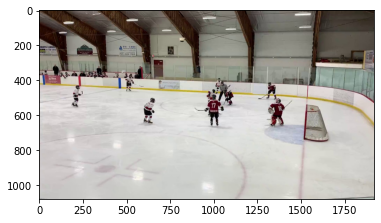

In [420]:
plt.imshow(source.astype("uint8"))
plt.show()

In [421]:
destination = np.zeros((1080, 1920, 3), "float32")

In [422]:
dest2 = cv2.warpPerspective(source, h, (950, 407))

In [423]:
dest2.shape

(407, 950, 3)

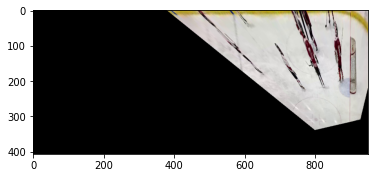

In [424]:
plt.imshow(dest2.astype("uint8"))
plt.show()

In [425]:
def get_bounds(transformed_corners, rink_im, padding):
    x_min = min(0, min(transformed_corners[0, :]))
    x_max = max(rink_im.shape[1], max(transformed_corners[0, :]))
    y_min = min(0, min(transformed_corners[1, :]))
    y_max = max(rink_im.shape[0], max(transformed_corners[1, :]))

    x_min -= padding
    y_min -= padding
    x_max += padding
    y_max += padding

    return x_min, x_max, y_min, y_max


In [426]:
def warp_image_onto_canvas(inputIm, hockey_im, H, x_min, x_max, y_min, y_max):
    x_width = int(x_max - x_min + 1)
    y_width = int(y_max - y_min + 1)
    canvasIm = np.zeros((y_width, x_width, 3))
    
    xs, ys, a = [], [], np.zeros((x_width, y_width))
    for index, _ in np.ndenumerate(a):
        xs.append(x_min + index[0]), ys.append(y_min + index[1])
    canvas_coords = np.vstack(
        (np.array(xs), np.array(ys), np.ones(len(xs))))
    transformed = np.matmul(np.linalg.inv(H), canvas_coords)
    xs = np.divide(transformed[0, :], transformed[2, :])
    ys = np.divide(transformed[1, :], transformed[2, :])
    inputIm_coords = np.transpose(np.column_stack((xs, ys)))

    def inside_input(x, y):
        return x >= 0 and x < inputIm.shape[1] and \
            y >= 0 and y < inputIm.shape[0]

    hickey_im_h, hickey_im_w, _ = hockey_im.shape
    for i in range(hickey_im_w):
        for j in range(hickey_im_h):
            canvasIm[j][i] = hockey_im[j][i]

    # Uncomment if you want to plot the warped image on the canvas

    for k in range(0, canvas_coords.shape[1]):
        x_canvas = int(canvas_coords[0, k] - x_min)
        y_canvas = int(canvas_coords[1, k] - y_min)
        x_input, y_input = int(inputIm_coords[0, k]), int(inputIm_coords[1, k])
        if inside_input(x_input, y_input):
            # Copy input image to refIm
            canvasIm[y_canvas, x_canvas] = inputIm[y_input, x_input]

    return np.array(canvasIm, dtype=int)


In [427]:
corners = np.array([[0, 0, 1], [WIDTH - 1, 0, 1],[WIDTH - 1, HEIGHT - 1, 1], [0, HEIGHT - 1, 1]]).transpose()
transformed_corners = np.matmul(h, corners)
transformed_corners = np.divide(transformed_corners, transformed_corners[2, :])

In [428]:
x1, _, y1, _ = get_bounds(transformed_corners, rink, PADDING)
top_left=(-x1, -y1)

In [429]:
f_y, f_x, f_z = rink.shape
new_rink_im = np.zeros((int(top_left[1]) + f_y, int(top_left[0]) + f_x, f_z))
new_rink_im[int(top_left[1]):, int(top_left[0]):, :] = rink

In [430]:
x_min, x_max, y_min, y_max = get_bounds(transformed_corners, new_rink_im, PADDING)

In [431]:
canvas = warp_image_onto_canvas(source, new_rink_im, h, x_min, x_max, y_min, y_max)

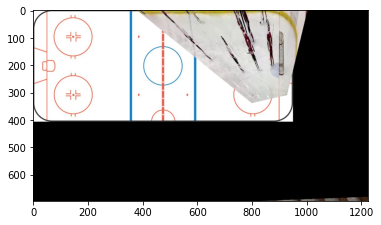

In [432]:
plt.imshow(canvas.astype("uint8"))
plt.show()

In [433]:
def get_edge_map(inputIm_shape, canvasIm, H):
    '''
    Input: inputIn_shape- shape of the edge map returned
    canvasIm- top view canvas with only the football field on it
    H- the calculated homography (camera view -> top view)
    '''
    xs, ys, a = [], [], np.zeros((inputIm_shape[1], inputIm_shape[0]))
    for index, _ in np.ndenumerate(a):
        xs.append(index[0]), ys.append(index[1])
    input_coords = np.vstack(
        (np.array(xs), np.array(ys), np.ones(len(xs))))
    transformed = np.matmul(H, input_coords)
    transformed[0, :] = np.divide(transformed[0, :], transformed[2, :])
    transformed[1, :] = np.divide(transformed[1, :], transformed[2, :])

    edge_map_perturb = np.zeros(inputIm_shape)
    for k in range(0, input_coords.shape[1]):
        x_input = int(input_coords[0, k])
        y_input = int(input_coords[1, k])
        x_canvas = int(transformed[0, k])
        y_canvas = int(transformed[1, k])
        if(0 <= y_canvas < canvasIm.shape[0] and 0 <= x_canvas < canvasIm.shape[1]):
            edge_map_perturb[y_input, x_input] = canvasIm[y_canvas, x_canvas]
    return edge_map_perturb

In [434]:
def slope_and_intercept(point1, point2):
    m = (point1[1] - point2[1]) * 1.0 / (point1[0] - point2[0])
    c = point1[1] - m * point1[0]
    return m, c


def find_intersection(m1, c1, m2, c2):
    x = (c2 - c1) * 1.0 / (m1 - m2)
    y = m1 * x + c1
    return np.array([x, y])


def find_polar(point, origin):
    diff = point - origin
    r = np.sqrt(np.sum(np.square(diff)))
    theta = np.arctan2(diff[1], diff[0])
    return r, theta


def find_cartesian(r, theta, origin):
    point = np.array([r * np.cos(theta), r * np.sin(theta)])
    return point + origin


def transform(r, theta, delta_theta):
    return r, theta + delta_theta


def pan(points, delta_theta=0.087):
    # Take Note: points are not homogenous, np.array([x, y]) form
    x0, y0 = points[0]  # p0 - TL
    x1, y1 = points[1]  # p1 - TR
    x2, y2 = points[2]  # p2 - BR
    x3, y3 = points[3]  # p3 - BL

    # Find L1
    m1, c1 = slope_and_intercept(points[0], points[3])

    # Find L2
    m2, c2 = slope_and_intercept(points[1], points[2])

    C = find_intersection(m1, c1, m2, c2)

    new_points = []
    for point in points:
        r, theta = find_polar(point, C)
        r, theta = transform(r, theta, delta_theta)
        x, y = find_cartesian(r, theta, C)
        new_points.append([x, y])

    return new_points


def apply_pan(shifted_corners, non_homo_corners, inputIm_shape, canvasIm):
    pert_points = np.array(pan(shifted_corners, delta_theta=0.18))
    # Create mask for perturbed trapezium
    # mask = getMask(pert_points, x_min, x_max, y_min, y_max)
    H_perturb = cv2.findHomography(non_homo_corners, pert_points)[0]
    edge_map_perturb = get_edge_map(inputIm_shape, canvasIm, H_perturb)
    return edge_map_perturb, H_perturb

In [435]:
def zoom(points,sx = 0.5, sy = 0.5):
    # points in order TL TR BR BL
    ones = np.ones(points.shape[0])
    homo_points = np.column_stack((points, ones.T))
    cx = np.mean(points[:, 0])
    cy = np.mean(points[:, 1])
    H = np.array([[sx, 0, 0], [0, sy, 0], [0, 0, 1]])
    I1 = np.array([[1, 0 ,-cx], [0, 1, -cy], [0, 0, 1]])
    I2 = np.array([[1, 0 ,cx], [0, 1, cy], [0, 0, 1]])
    zoom_center = np.matmul(H , I1)
    outputs = np.matmul(I2,np.matmul(zoom_center, homo_points.T))[:-1,:].T
    
    return outputs


def apply_zoom(shifted_corners, non_homo_corners, inputIm_shape, canvasIm):
    pert_points = np.array(zoom(shifted_corners, sx=0.85, sy=0.85))
    # Create mask for perturbed trapezium
    # mask = getMask(pert_points, x_min, x_max, y_min, y_max)
    H_perturb = cv2.findHomography(non_homo_corners, pert_points)[0]
    edge_map_perturb = get_edge_map(inputIm_shape, canvasIm, H_perturb)
    return edge_map_perturb, H_perturb

In [436]:
def tilt(points,t = 0.1):
	#points in order TL TR BR BL
	output = np.zeros(points.shape)
	output[0] = (1-t)*points[0] + t*points[3]
	output[3] = (-t)*points[0] + (t+1)*points[3]
	output[1] = (1-t)*points[1] + t*points[2]
	output[2] = (-t)*points[1] + (t+1)*points[2]

	return output


def apply_tilt(shifted_corners, non_homo_corners, inputIm_shape, canvasIm):
    pert_points = np.array(tilt(shifted_corners,t=0.035))
    # Create mask for perturbed trapezium
    # mask = getMask(pert_points, x_min, x_max, y_min, y_max)
    H_perturb = cv2.findHomography(non_homo_corners, pert_points)[0]
    edge_map_perturb = get_edge_map(inputIm_shape, canvasIm, H_perturb)
    return edge_map_perturb, H_perturb

In [437]:
def apply_perturbation(corners, transformed_corners, canvasIm, inputIm,
                       x_min, x_max, y_min, y_max, H_base=h):
    '''
    This is the wrapper function that creates all sorts of perturbations
    to the warped input image and finds the homographies that map it back
    a rectangle of the input shape. In doing so, we create a dictionary
    of edgeMap -> homography (camera view to top view)
    '''
    # Need to shift corners to map them to the canvas with H
    shifted_corners = np.array([[corner[0] - x_min, corner[1] - y_min]
                                for corner in transformed_corners.T])

    # Find the H for rect to perturbed trapezium
    non_homo_corners = np.array([[corner[0], corner[1]]
                                 for corner in corners.T])
    plt.imshow(inputIm.astype('uint8'))
    plt.title("InputIm")
    plt.show()

    # First pair is directly the edge map for inputIm and the homography
#     H_base = cv2.findHomography(non_homo_corners, shifted_corners)[0]
    edge_map = get_edge_map(inputIm.shape, canvasIm, H_base)
    plt.imshow(edge_map.astype('uint8'))
    plt.title("Original")
    plt.show()

    # Generate more pairs for different perturbations
    # Get trapezium after applying zoom perturbation
    edge_map_zoom, H_zoom = apply_zoom(
        shifted_corners, non_homo_corners, inputIm.shape, canvasIm)
    plt.imshow(edge_map_zoom.astype('uint8'))
    plt.title("Zoom")
    plt.show()

    # Get trapezium after applying pan perturbation
    edge_map_pan, H_pan = apply_pan(
        shifted_corners, non_homo_corners, inputIm.shape, canvasIm)
    plt.imshow(edge_map_pan.astype('uint8'))
    plt.title("Pan")
    plt.show()

    # Get trapezium after applying tilt perturbation
    edge_map_tilt, H_tilt = apply_tilt(
        shifted_corners, non_homo_corners, inputIm.shape, canvasIm)
    plt.imshow(edge_map_tilt.astype('uint8'))
    plt.title("Tilt")
    plt.show()

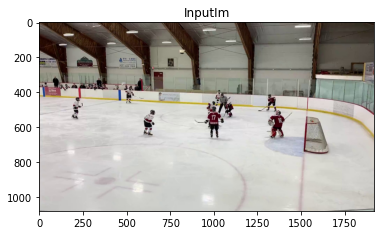

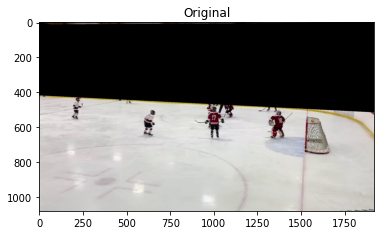

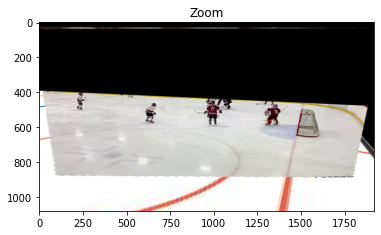

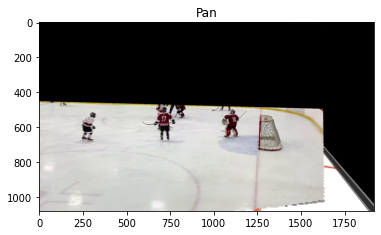

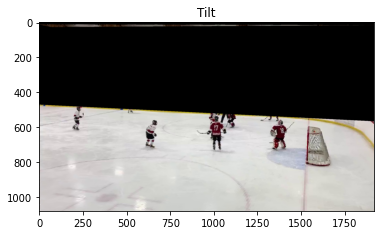

In [438]:
apply_perturbation(corners, transformed_corners, canvas, source, x_min, x_max, y_min, y_max)

In [439]:
h2 = np.linalg.inv(h)
dest3 = cv2.warpPerspective(rink, h2, (WIDTH, HEIGHT))

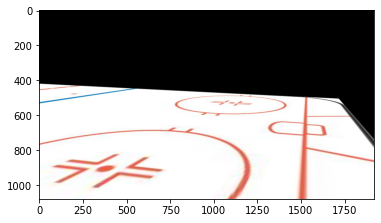

In [440]:
plt.imshow(dest3.astype("uint8"))
plt.show()

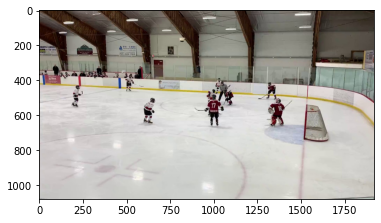

In [441]:
plt.imshow(source.astype("uint8"))
plt.show()